In [ ]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [ ]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip

--2020-09-20 19:09:14--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.24.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.24.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip’

summer2winter-yosem 100%[===================>] 127.58M  53.2MB/s    in 2.4s    

2020-09-20 19:09:17 (53.2 MB/s) - ‘summer2winter-yosemite.zip’ saved [133783376/133783376]



In [ ]:
!unzip summer2winter-yosemite.zip

Streaming output truncated to the last 5000 lines.
  inflating: summer2winter_yosemite/summer/summer/2012-06-01 16:14:33.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-01 16:14:33.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-01 19:37:52.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-01 19:37:52.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-03 20:17:16.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-03 20:17:16.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-04 13:38:16.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-04 13:38:16.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-04 19:59:13.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer/._2012-06-04 19:59:13.jpg  
  inflating: summer2winter_yosemite/summer/summer/2012-06-05 06:09:05.jpg  
  inflating: __MACOSX/summer2winter_yosemite/summer/summer

In [ ]:
!ls

__MACOSX  sample_data  summer2winter_yosemite  summer2winter-yosemite.zip


In [ ]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

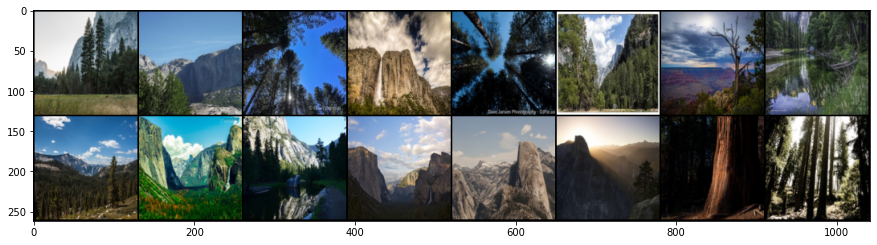

In [ ]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(15, 8))
imshow(torchvision.utils.make_grid(images))

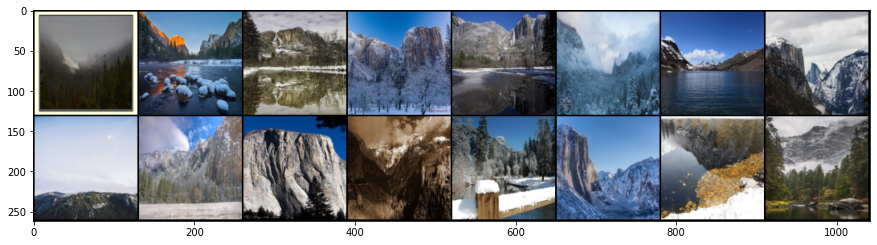

In [ ]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(15,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [ ]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0078)
Max:  tensor(1.)


In [ ]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9843)
Scaled max:  tensor(1.)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0.

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture
Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> We use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

We should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training.

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.layer_1 = conv(3,conv_dim,4,batch_norm = False)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        self.layer_4 = conv(conv_dim*4,conv_dim*8,4)
        self.layer_5 = conv(conv_dim*8,1,4,1,batch_norm = False)

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = F.relu(self.layer_4(x))
        
        x = self.layer_5(x)
        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. 

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block?

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [ ]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.layer_1 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)
        self.layer_2 = conv(conv_dim,conv_dim,3,1,1,batch_norm = True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.layer_1(x))
        out_2 = x + self.layer_2(out_1)
        
        return out_2

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [ ]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* The `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [ ]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.layer_1 = conv(3,conv_dim,4)
        self.layer_2 = conv(conv_dim,conv_dim*2,4)
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4)
        # 2. Define the resnet part of the generator
        layers = []
        for n in range(n_res_blocks):
            layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*layers)
        # 3. Define the decoder part of the generator
        self.layer_4 = deconv(conv_dim*4,conv_dim*2,4)
        self.layer_5 = deconv(conv_dim*2,conv_dim,4)
        self.layer_6 = deconv(conv_dim,3,4,batch_norm = False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        
        out = F.relu(self.layer_1(x))
        out = F.relu(self.layer_2(out))
        out = F.relu(self.layer_3(out))
        
        out = self.res_blocks(out)
        
        out = F.relu(self.layer_4(out))
        out = F.relu(self.layer_5(out))
        out = F.tanh(self.layer_6(out))
        
        return out

---
## Create the complete network

Using the classes we defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [ ]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim,n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim,n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)
    

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [ ]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that we've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After we've defined these discriminator and generator components, it's good practice to check our work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [ ]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (layer_1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.

In [ ]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out - 1)**2)

    
def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return loss*lambda_weight


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.

In [ ]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr= 0.0002
beta1= 0.5
beta2= 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [ ]:
###################### helper #############################
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

import imageio

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    #scipy.misc.imsave(path, merged)
    imageio.imwrite(path,merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    #scipy.misc.imsave(path, merged)
    imageio.imwrite(path,merged)
    print('Saved {}'.format(path))

# TrainingLOOP

In [ ]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # 1. Compute the discriminator losses on real images
        d_x_optimizer.zero_grad()
        real_D_loss = real_mse_loss(D_X(images_X))
        # 3. Compute the fake loss for D_X
        fake_D_loss = fake_mse_loss(D_X(G_YtoX(images_Y)))
        # 4. Compute the total loss and perform backprop
        d_x_loss = real_D_loss + fake_D_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()
        real_D_y_loss = real_mse_loss(D_Y(images_Y))
        
        fake_D_y_loss = fake_mse_loss(D_Y(G_XtoY(images_X)))
        
        d_y_loss = real_D_y_loss + fake_D_y_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
        # 1. Generate fake images that look like domain X based on real images in domain Y
        out_1 = G_YtoX(images_Y)
        # 2. Compute the generator loss based on domain X
        loss_1 = real_mse_loss(D_X(out_1))
        # 3. Create a reconstructed y
        out_2 = G_XtoY(out_1)
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        loss_2 = cycle_consistency_loss(real_im = images_Y, reconstructed_im = out_2, lambda_weight=10)

        ##    Second: generate fake Y images and reconstructed X images    ##
        out_3 = G_XtoY(images_X)
        # 5. Add up all generator and reconstructed losses and perform backprop
        loss_3 = real_mse_loss(D_Y(out_3))
        out_4 = G_YtoX(out_3)
        loss_4 =  cycle_consistency_loss(real_im = images_X, reconstructed_im = out_4, lambda_weight=10)

        g_total_loss = loss_1 + loss_2 + loss_3 + loss_4
        g_total_loss.backward()
        g_optimizer.step()
        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [ ]:
!mkdir samples_cyclegan

In [ ]:
!ls

__MACOSX     samples_cyclegan	     summer2winter-yosemite.zip
sample_data  summer2winter_yosemite


In [ ]:
n_epochs = 5000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.2535 | d_Y_loss: 0.2659 | g_total_loss: 4.2074
Epoch [   20/ 5000] | d_X_loss: 0.3312 | d_Y_loss: 0.2477 | g_total_loss: 4.3131
Epoch [   30/ 5000] | d_X_loss: 0.2501 | d_Y_loss: 0.4201 | g_total_loss: 5.7587
Epoch [   40/ 5000] | d_X_loss: 0.2486 | d_Y_loss: 0.5178 | g_total_loss: 5.5355
Epoch [   50/ 5000] | d_X_loss: 0.3267 | d_Y_loss: 0.3365 | g_total_loss: 5.4581
Epoch [   60/ 5000] | d_X_loss: 0.4173 | d_Y_loss: 0.3348 | g_total_loss: 4.8139
Epoch [   70/ 5000] | d_X_loss: 0.2570 | d_Y_loss: 0.5130 | g_total_loss: 3.9668
Epoch [   80/ 5000] | d_X_loss: 0.3406 | d_Y_loss: 0.4275 | g_total_loss: 4.4693
Epoch [   90/ 5000] | d_X_loss: 0.3343 | d_Y_loss: 0.3810 | g_total_loss: 5.3047


Epoch [  100/ 5000] | d_X_loss: 0.5820 | d_Y_loss: 0.3011 | g_total_loss: 5.1842


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 5000] | d_X_loss: 0.4721 | d_Y_loss: 0.5796 | g_total_loss: 5.0565
Epoch [  120/ 5000] | d_X_loss: 0.5466 | d_Y_loss: 0.3157 | g_total_loss: 5.2670
Epoch [  130/ 5000] | d_X_loss: 0.4852 | d_Y_loss: 0.3577 | g_total_loss: 4.3636
Epoch [  140/ 5000] | d_X_loss: 0.4378 | d_Y_loss: 0.2814 | g_total_loss: 4.4415
Epoch [  150/ 5000] | d_X_loss: 0.6367 | d_Y_loss: 0.3806 | g_total_loss: 5.1894
Epoch [  160/ 5000] | d_X_loss: 0.3533 | d_Y_loss: 0.3075 | g_total_loss: 4.6344
Epoch [  170/ 5000] | d_X_loss: 0.7092 | d_Y_loss: 0.3398 | g_total_loss: 4.9721
Epoch [  180/ 5000] | d_X_loss: 0.5059 | d_Y_loss: 0.3649 | g_total_loss: 5.2160
Epoch [  190/ 5000] | d_X_loss: 0.2494 | d_Y_loss: 0.2674 | g_total_loss: 4.7870


Epoch [  200/ 5000] | d_X_loss: 0.3326 | d_Y_loss: 0.4642 | g_total_loss: 4.1610


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 5000] | d_X_loss: 0.3809 | d_Y_loss: 0.5902 | g_total_loss: 4.2149
Epoch [  220/ 5000] | d_X_loss: 0.5540 | d_Y_loss: 0.4409 | g_total_loss: 5.5827
Epoch [  230/ 5000] | d_X_loss: 0.3993 | d_Y_loss: 0.3092 | g_total_loss: 4.8785
Epoch [  240/ 5000] | d_X_loss: 0.2903 | d_Y_loss: 0.3271 | g_total_loss: 5.4053
Epoch [  250/ 5000] | d_X_loss: 0.3232 | d_Y_loss: 0.4236 | g_total_loss: 4.4740
Epoch [  260/ 5000] | d_X_loss: 0.4412 | d_Y_loss: 0.4999 | g_total_loss: 4.1229
Epoch [  270/ 5000] | d_X_loss: 0.4711 | d_Y_loss: 0.3954 | g_total_loss: 4.6294
Epoch [  280/ 5000] | d_X_loss: 0.3525 | d_Y_loss: 0.4527 | g_total_loss: 4.4788
Epoch [  290/ 5000] | d_X_loss: 0.2688 | d_Y_loss: 0.2907 | g_total_loss: 4.7978


Epoch [  300/ 5000] | d_X_loss: 0.4583 | d_Y_loss: 0.3741 | g_total_loss: 4.4515


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 5000] | d_X_loss: 0.4003 | d_Y_loss: 0.4451 | g_total_loss: 4.5184
Epoch [  320/ 5000] | d_X_loss: 0.4014 | d_Y_loss: 0.3890 | g_total_loss: 4.4871
Epoch [  330/ 5000] | d_X_loss: 0.4860 | d_Y_loss: 0.3801 | g_total_loss: 4.0784
Epoch [  340/ 5000] | d_X_loss: 0.4459 | d_Y_loss: 0.8489 | g_total_loss: 4.4394
Epoch [  350/ 5000] | d_X_loss: 0.4931 | d_Y_loss: 0.4577 | g_total_loss: 3.6852
Epoch [  360/ 5000] | d_X_loss: 0.4494 | d_Y_loss: 0.3366 | g_total_loss: 3.8787
Epoch [  370/ 5000] | d_X_loss: 0.1453 | d_Y_loss: 0.3252 | g_total_loss: 4.7573
Epoch [  380/ 5000] | d_X_loss: 0.3481 | d_Y_loss: 0.4841 | g_total_loss: 4.2448
Epoch [  390/ 5000] | d_X_loss: 0.5943 | d_Y_loss: 0.3113 | g_total_loss: 5.1866


Epoch [  400/ 5000] | d_X_loss: 0.4414 | d_Y_loss: 0.5195 | g_total_loss: 3.9468


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 5000] | d_X_loss: 0.6310 | d_Y_loss: 0.3719 | g_total_loss: 4.5037
Epoch [  420/ 5000] | d_X_loss: 0.4358 | d_Y_loss: 0.4133 | g_total_loss: 4.0560
Epoch [  430/ 5000] | d_X_loss: 0.4974 | d_Y_loss: 0.2198 | g_total_loss: 3.8101
Epoch [  440/ 5000] | d_X_loss: 0.3712 | d_Y_loss: 0.3162 | g_total_loss: 3.5269
Epoch [  450/ 5000] | d_X_loss: 0.2946 | d_Y_loss: 0.3653 | g_total_loss: 4.1847
Epoch [  460/ 5000] | d_X_loss: 0.3347 | d_Y_loss: 0.4397 | g_total_loss: 4.2945
Epoch [  470/ 5000] | d_X_loss: 0.3007 | d_Y_loss: 0.5610 | g_total_loss: 4.1483
Epoch [  480/ 5000] | d_X_loss: 0.3815 | d_Y_loss: 0.3688 | g_total_loss: 4.1885
Epoch [  490/ 5000] | d_X_loss: 0.5179 | d_Y_loss: 0.8388 | g_total_loss: 4.3169


Epoch [  500/ 5000] | d_X_loss: 0.3949 | d_Y_loss: 0.2650 | g_total_loss: 4.5317


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 5000] | d_X_loss: 0.3303 | d_Y_loss: 0.2314 | g_total_loss: 3.8178
Epoch [  520/ 5000] | d_X_loss: 0.3522 | d_Y_loss: 0.3130 | g_total_loss: 4.1518
Epoch [  530/ 5000] | d_X_loss: 0.3822 | d_Y_loss: 0.2440 | g_total_loss: 4.5152
Epoch [  540/ 5000] | d_X_loss: 0.4635 | d_Y_loss: 0.3691 | g_total_loss: 4.7109
Epoch [  550/ 5000] | d_X_loss: 0.6441 | d_Y_loss: 0.5514 | g_total_loss: 5.1786
Epoch [  560/ 5000] | d_X_loss: 0.3378 | d_Y_loss: 0.3367 | g_total_loss: 4.6973
Epoch [  570/ 5000] | d_X_loss: 0.2873 | d_Y_loss: 0.3551 | g_total_loss: 4.6815
Epoch [  580/ 5000] | d_X_loss: 0.5812 | d_Y_loss: 0.3123 | g_total_loss: 4.9413
Epoch [  590/ 5000] | d_X_loss: 0.4059 | d_Y_loss: 0.4207 | g_total_loss: 4.1620


Epoch [  600/ 5000] | d_X_loss: 0.4679 | d_Y_loss: 0.2112 | g_total_loss: 3.7072


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 5000] | d_X_loss: 0.2490 | d_Y_loss: 0.7720 | g_total_loss: 4.4305
Epoch [  620/ 5000] | d_X_loss: 0.3210 | d_Y_loss: 0.4209 | g_total_loss: 5.0309
Epoch [  630/ 5000] | d_X_loss: 0.3731 | d_Y_loss: 0.3550 | g_total_loss: 4.2701
Epoch [  640/ 5000] | d_X_loss: 0.1904 | d_Y_loss: 0.2636 | g_total_loss: 4.0275
Epoch [  650/ 5000] | d_X_loss: 0.3591 | d_Y_loss: 0.3386 | g_total_loss: 4.1238
Epoch [  660/ 5000] | d_X_loss: 0.2618 | d_Y_loss: 0.3640 | g_total_loss: 4.6412
Epoch [  670/ 5000] | d_X_loss: 0.1587 | d_Y_loss: 0.2950 | g_total_loss: 5.1637
Epoch [  680/ 5000] | d_X_loss: 0.2325 | d_Y_loss: 0.4228 | g_total_loss: 3.8285
Epoch [  690/ 5000] | d_X_loss: 0.2858 | d_Y_loss: 0.2614 | g_total_loss: 3.7300


Epoch [  700/ 5000] | d_X_loss: 0.4864 | d_Y_loss: 0.2140 | g_total_loss: 4.8382


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 5000] | d_X_loss: 0.6236 | d_Y_loss: 0.3438 | g_total_loss: 4.1407
Epoch [  720/ 5000] | d_X_loss: 0.3249 | d_Y_loss: 0.5076 | g_total_loss: 4.9645
Epoch [  730/ 5000] | d_X_loss: 0.4665 | d_Y_loss: 0.3646 | g_total_loss: 3.7028
Epoch [  740/ 5000] | d_X_loss: 0.3319 | d_Y_loss: 0.2791 | g_total_loss: 4.5000
Epoch [  750/ 5000] | d_X_loss: 0.3542 | d_Y_loss: 0.1756 | g_total_loss: 4.0602
Epoch [  760/ 5000] | d_X_loss: 0.4651 | d_Y_loss: 0.2532 | g_total_loss: 3.7552
Epoch [  770/ 5000] | d_X_loss: 0.2703 | d_Y_loss: 0.3386 | g_total_loss: 4.1659
Epoch [  780/ 5000] | d_X_loss: 0.5901 | d_Y_loss: 0.3759 | g_total_loss: 4.2611
Epoch [  790/ 5000] | d_X_loss: 0.2913 | d_Y_loss: 0.2017 | g_total_loss: 4.6119


Epoch [  800/ 5000] | d_X_loss: 0.1703 | d_Y_loss: 0.2236 | g_total_loss: 4.7125


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 5000] | d_X_loss: 0.8832 | d_Y_loss: 0.3593 | g_total_loss: 4.2269
Epoch [  820/ 5000] | d_X_loss: 0.3048 | d_Y_loss: 0.3190 | g_total_loss: 4.2272
Epoch [  830/ 5000] | d_X_loss: 0.3408 | d_Y_loss: 0.4482 | g_total_loss: 4.2140
Epoch [  840/ 5000] | d_X_loss: 0.2691 | d_Y_loss: 0.5741 | g_total_loss: 3.7820
Epoch [  850/ 5000] | d_X_loss: 0.2749 | d_Y_loss: 0.5413 | g_total_loss: 3.6605
Epoch [  860/ 5000] | d_X_loss: 0.1793 | d_Y_loss: 0.2625 | g_total_loss: 4.3690
Epoch [  870/ 5000] | d_X_loss: 0.3409 | d_Y_loss: 0.3996 | g_total_loss: 4.7156
Epoch [  880/ 5000] | d_X_loss: 0.0910 | d_Y_loss: 0.3474 | g_total_loss: 4.3062
Epoch [  890/ 5000] | d_X_loss: 0.7309 | d_Y_loss: 0.6962 | g_total_loss: 5.0743


Epoch [  900/ 5000] | d_X_loss: 0.2602 | d_Y_loss: 0.4237 | g_total_loss: 3.5801


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 5000] | d_X_loss: 0.2924 | d_Y_loss: 0.1719 | g_total_loss: 3.8769
Epoch [  920/ 5000] | d_X_loss: 0.1840 | d_Y_loss: 0.3143 | g_total_loss: 4.4017
Epoch [  930/ 5000] | d_X_loss: 0.7197 | d_Y_loss: 0.2651 | g_total_loss: 4.2844
Epoch [  940/ 5000] | d_X_loss: 0.3278 | d_Y_loss: 0.3924 | g_total_loss: 3.1090
Epoch [  950/ 5000] | d_X_loss: 0.3815 | d_Y_loss: 0.2898 | g_total_loss: 4.0655
Epoch [  960/ 5000] | d_X_loss: 0.3487 | d_Y_loss: 0.3609 | g_total_loss: 4.8826
Epoch [  970/ 5000] | d_X_loss: 0.3509 | d_Y_loss: 0.4906 | g_total_loss: 3.2483
Epoch [  980/ 5000] | d_X_loss: 0.3810 | d_Y_loss: 0.4674 | g_total_loss: 3.3893
Epoch [  990/ 5000] | d_X_loss: 0.4653 | d_Y_loss: 0.1795 | g_total_loss: 5.2295


Epoch [ 1000/ 5000] | d_X_loss: 0.3095 | d_Y_loss: 0.3811 | g_total_loss: 5.4785


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 5000] | d_X_loss: 0.2667 | d_Y_loss: 0.4325 | g_total_loss: 3.9482
Epoch [ 1020/ 5000] | d_X_loss: 0.3270 | d_Y_loss: 0.4372 | g_total_loss: 4.0674
Epoch [ 1030/ 5000] | d_X_loss: 0.2956 | d_Y_loss: 0.3182 | g_total_loss: 4.2223
Epoch [ 1040/ 5000] | d_X_loss: 0.3018 | d_Y_loss: 0.2912 | g_total_loss: 4.1616
Epoch [ 1050/ 5000] | d_X_loss: 0.4441 | d_Y_loss: 0.4610 | g_total_loss: 3.5851
Epoch [ 1060/ 5000] | d_X_loss: 0.2588 | d_Y_loss: 0.1499 | g_total_loss: 3.5488
Epoch [ 1070/ 5000] | d_X_loss: 0.2669 | d_Y_loss: 0.4134 | g_total_loss: 4.2997
Epoch [ 1080/ 5000] | d_X_loss: 0.4332 | d_Y_loss: 0.3160 | g_total_loss: 3.8656
Epoch [ 1090/ 5000] | d_X_loss: 0.4001 | d_Y_loss: 0.5454 | g_total_loss: 4.7343


Epoch [ 1100/ 5000] | d_X_loss: 0.1875 | d_Y_loss: 0.7459 | g_total_loss: 4.5421


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 5000] | d_X_loss: 0.4010 | d_Y_loss: 0.3256 | g_total_loss: 4.4780
Epoch [ 1120/ 5000] | d_X_loss: 0.2516 | d_Y_loss: 0.3307 | g_total_loss: 4.2754
Epoch [ 1130/ 5000] | d_X_loss: 0.2631 | d_Y_loss: 0.3186 | g_total_loss: 3.9254
Epoch [ 1140/ 5000] | d_X_loss: 0.3315 | d_Y_loss: 0.3465 | g_total_loss: 4.1905
Epoch [ 1150/ 5000] | d_X_loss: 0.2530 | d_Y_loss: 0.5266 | g_total_loss: 3.6157
Epoch [ 1160/ 5000] | d_X_loss: 0.4345 | d_Y_loss: 0.4264 | g_total_loss: 5.7867
Epoch [ 1170/ 5000] | d_X_loss: 0.5929 | d_Y_loss: 0.3175 | g_total_loss: 5.0815
Epoch [ 1180/ 5000] | d_X_loss: 0.2392 | d_Y_loss: 0.5236 | g_total_loss: 4.7102
Epoch [ 1190/ 5000] | d_X_loss: 0.1437 | d_Y_loss: 0.2606 | g_total_loss: 3.5041


Epoch [ 1200/ 5000] | d_X_loss: 0.6259 | d_Y_loss: 0.3545 | g_total_loss: 3.0668


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 5000] | d_X_loss: 0.6365 | d_Y_loss: 0.3626 | g_total_loss: 3.7601
Epoch [ 1220/ 5000] | d_X_loss: 0.4354 | d_Y_loss: 0.4393 | g_total_loss: 4.2906
Epoch [ 1230/ 5000] | d_X_loss: 0.4111 | d_Y_loss: 0.2333 | g_total_loss: 4.1751
Epoch [ 1240/ 5000] | d_X_loss: 0.2381 | d_Y_loss: 0.1965 | g_total_loss: 4.0335
Epoch [ 1250/ 5000] | d_X_loss: 0.3253 | d_Y_loss: 0.4397 | g_total_loss: 5.0122
Epoch [ 1260/ 5000] | d_X_loss: 0.2790 | d_Y_loss: 0.3494 | g_total_loss: 6.6874
Epoch [ 1270/ 5000] | d_X_loss: 0.3134 | d_Y_loss: 0.2372 | g_total_loss: 4.3920
Epoch [ 1280/ 5000] | d_X_loss: 0.1727 | d_Y_loss: 0.1394 | g_total_loss: 4.7385
Epoch [ 1290/ 5000] | d_X_loss: 0.1025 | d_Y_loss: 0.2894 | g_total_loss: 4.7948


Epoch [ 1300/ 5000] | d_X_loss: 0.2961 | d_Y_loss: 0.3370 | g_total_loss: 5.2659


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 5000] | d_X_loss: 0.0918 | d_Y_loss: 0.2713 | g_total_loss: 4.1511
Epoch [ 1320/ 5000] | d_X_loss: 0.2887 | d_Y_loss: 0.2481 | g_total_loss: 4.6029
Epoch [ 1330/ 5000] | d_X_loss: 0.3523 | d_Y_loss: 0.3203 | g_total_loss: 3.8881
Epoch [ 1340/ 5000] | d_X_loss: 0.4381 | d_Y_loss: 0.1912 | g_total_loss: 3.7770
Epoch [ 1350/ 5000] | d_X_loss: 0.2174 | d_Y_loss: 0.2110 | g_total_loss: 4.1969
Epoch [ 1360/ 5000] | d_X_loss: 0.2388 | d_Y_loss: 0.3207 | g_total_loss: 4.6617
Epoch [ 1370/ 5000] | d_X_loss: 0.1217 | d_Y_loss: 0.3411 | g_total_loss: 3.9902
Epoch [ 1380/ 5000] | d_X_loss: 0.2198 | d_Y_loss: 0.1453 | g_total_loss: 4.2982
Epoch [ 1390/ 5000] | d_X_loss: 0.2346 | d_Y_loss: 0.2578 | g_total_loss: 4.7504


Epoch [ 1400/ 5000] | d_X_loss: 0.1717 | d_Y_loss: 0.2561 | g_total_loss: 4.1235


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 5000] | d_X_loss: 0.4481 | d_Y_loss: 0.2246 | g_total_loss: 2.9790
Epoch [ 1420/ 5000] | d_X_loss: 0.1811 | d_Y_loss: 0.2612 | g_total_loss: 3.7891
Epoch [ 1430/ 5000] | d_X_loss: 0.3317 | d_Y_loss: 0.1853 | g_total_loss: 4.0586
Epoch [ 1440/ 5000] | d_X_loss: 0.1772 | d_Y_loss: 0.2112 | g_total_loss: 4.7252
Epoch [ 1450/ 5000] | d_X_loss: 0.2803 | d_Y_loss: 0.5788 | g_total_loss: 5.5143
Epoch [ 1460/ 5000] | d_X_loss: 0.1845 | d_Y_loss: 0.2245 | g_total_loss: 4.5750
Epoch [ 1470/ 5000] | d_X_loss: 0.1657 | d_Y_loss: 0.3723 | g_total_loss: 3.7360
Epoch [ 1480/ 5000] | d_X_loss: 0.2221 | d_Y_loss: 0.4300 | g_total_loss: 3.4650
Epoch [ 1490/ 5000] | d_X_loss: 0.3746 | d_Y_loss: 0.2598 | g_total_loss: 4.2541


Epoch [ 1500/ 5000] | d_X_loss: 0.2526 | d_Y_loss: 0.2163 | g_total_loss: 3.8145


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 5000] | d_X_loss: 0.1861 | d_Y_loss: 0.3316 | g_total_loss: 3.4142
Epoch [ 1520/ 5000] | d_X_loss: 0.3098 | d_Y_loss: 0.1494 | g_total_loss: 4.5976
Epoch [ 1530/ 5000] | d_X_loss: 0.0595 | d_Y_loss: 0.1616 | g_total_loss: 3.8151
Epoch [ 1540/ 5000] | d_X_loss: 0.1347 | d_Y_loss: 0.2187 | g_total_loss: 3.9824
Epoch [ 1550/ 5000] | d_X_loss: 0.2454 | d_Y_loss: 0.2183 | g_total_loss: 3.8640
Epoch [ 1560/ 5000] | d_X_loss: 0.4434 | d_Y_loss: 0.2728 | g_total_loss: 3.3071
Epoch [ 1570/ 5000] | d_X_loss: 0.1328 | d_Y_loss: 0.2236 | g_total_loss: 4.8992
Epoch [ 1580/ 5000] | d_X_loss: 0.3169 | d_Y_loss: 0.1812 | g_total_loss: 3.5524
Epoch [ 1590/ 5000] | d_X_loss: 0.4267 | d_Y_loss: 0.2180 | g_total_loss: 3.2066


Epoch [ 1600/ 5000] | d_X_loss: 0.1280 | d_Y_loss: 0.2966 | g_total_loss: 4.3770


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 5000] | d_X_loss: 0.4536 | d_Y_loss: 0.1934 | g_total_loss: 4.3016
Epoch [ 1620/ 5000] | d_X_loss: 0.2649 | d_Y_loss: 0.2513 | g_total_loss: 3.6129
Epoch [ 1630/ 5000] | d_X_loss: 0.1693 | d_Y_loss: 0.2137 | g_total_loss: 3.8625
Epoch [ 1640/ 5000] | d_X_loss: 0.3244 | d_Y_loss: 0.6859 | g_total_loss: 5.5650
Epoch [ 1650/ 5000] | d_X_loss: 0.2435 | d_Y_loss: 0.1404 | g_total_loss: 4.2242
Epoch [ 1660/ 5000] | d_X_loss: 0.2104 | d_Y_loss: 0.3779 | g_total_loss: 5.6191
Epoch [ 1670/ 5000] | d_X_loss: 0.5157 | d_Y_loss: 0.3801 | g_total_loss: 3.9408
Epoch [ 1680/ 5000] | d_X_loss: 0.2245 | d_Y_loss: 0.1654 | g_total_loss: 4.4554
Epoch [ 1690/ 5000] | d_X_loss: 0.2316 | d_Y_loss: 0.3829 | g_total_loss: 3.8367


Epoch [ 1700/ 5000] | d_X_loss: 0.4447 | d_Y_loss: 0.2137 | g_total_loss: 3.9172


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 5000] | d_X_loss: 0.2063 | d_Y_loss: 0.1970 | g_total_loss: 4.7586
Epoch [ 1720/ 5000] | d_X_loss: 0.3225 | d_Y_loss: 0.1821 | g_total_loss: 3.9607
Epoch [ 1730/ 5000] | d_X_loss: 0.3471 | d_Y_loss: 0.3386 | g_total_loss: 5.2727
Epoch [ 1740/ 5000] | d_X_loss: 0.1207 | d_Y_loss: 0.2270 | g_total_loss: 4.1102
Epoch [ 1750/ 5000] | d_X_loss: 0.3124 | d_Y_loss: 0.2581 | g_total_loss: 4.5240
Epoch [ 1760/ 5000] | d_X_loss: 0.1633 | d_Y_loss: 0.1978 | g_total_loss: 3.8937
Epoch [ 1770/ 5000] | d_X_loss: 0.1568 | d_Y_loss: 0.6020 | g_total_loss: 4.9763
Epoch [ 1780/ 5000] | d_X_loss: 0.6541 | d_Y_loss: 0.1495 | g_total_loss: 5.5928
Epoch [ 1790/ 5000] | d_X_loss: 0.1187 | d_Y_loss: 0.2249 | g_total_loss: 3.4472


Epoch [ 1800/ 5000] | d_X_loss: 0.1801 | d_Y_loss: 0.2466 | g_total_loss: 4.1167


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 5000] | d_X_loss: 0.3160 | d_Y_loss: 0.5627 | g_total_loss: 2.7639
Epoch [ 1820/ 5000] | d_X_loss: 0.1940 | d_Y_loss: 0.1544 | g_total_loss: 3.7005
Epoch [ 1830/ 5000] | d_X_loss: 0.1906 | d_Y_loss: 0.1694 | g_total_loss: 4.4729
Epoch [ 1840/ 5000] | d_X_loss: 0.3596 | d_Y_loss: 0.5592 | g_total_loss: 3.1860
Epoch [ 1850/ 5000] | d_X_loss: 0.2698 | d_Y_loss: 0.1946 | g_total_loss: 3.9115
Epoch [ 1860/ 5000] | d_X_loss: 0.5777 | d_Y_loss: 0.1628 | g_total_loss: 3.7288
Epoch [ 1870/ 5000] | d_X_loss: 0.2206 | d_Y_loss: 0.1423 | g_total_loss: 4.6170
Epoch [ 1880/ 5000] | d_X_loss: 0.1809 | d_Y_loss: 0.1204 | g_total_loss: 4.0989
Epoch [ 1890/ 5000] | d_X_loss: 0.2761 | d_Y_loss: 0.1590 | g_total_loss: 4.2423


Epoch [ 1900/ 5000] | d_X_loss: 0.1077 | d_Y_loss: 0.3019 | g_total_loss: 4.1609


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 5000] | d_X_loss: 0.2124 | d_Y_loss: 0.2497 | g_total_loss: 4.3157
Epoch [ 1920/ 5000] | d_X_loss: 0.2023 | d_Y_loss: 0.2701 | g_total_loss: 4.5809
Epoch [ 1930/ 5000] | d_X_loss: 0.2322 | d_Y_loss: 0.2266 | g_total_loss: 4.3679
Epoch [ 1940/ 5000] | d_X_loss: 0.2574 | d_Y_loss: 0.1760 | g_total_loss: 4.6953
Epoch [ 1950/ 5000] | d_X_loss: 0.2276 | d_Y_loss: 0.0814 | g_total_loss: 4.4402
Epoch [ 1960/ 5000] | d_X_loss: 0.2054 | d_Y_loss: 0.1806 | g_total_loss: 3.5158
Epoch [ 1970/ 5000] | d_X_loss: 0.0992 | d_Y_loss: 0.1543 | g_total_loss: 4.1255
Epoch [ 1980/ 5000] | d_X_loss: 0.2490 | d_Y_loss: 0.1983 | g_total_loss: 4.1900
Epoch [ 1990/ 5000] | d_X_loss: 0.3722 | d_Y_loss: 0.2778 | g_total_loss: 5.6079


Epoch [ 2000/ 5000] | d_X_loss: 0.2586 | d_Y_loss: 0.4756 | g_total_loss: 4.1397


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 5000] | d_X_loss: 0.1162 | d_Y_loss: 0.1540 | g_total_loss: 4.2602
Epoch [ 2020/ 5000] | d_X_loss: 0.0491 | d_Y_loss: 0.1485 | g_total_loss: 3.9552
Epoch [ 2030/ 5000] | d_X_loss: 0.1560 | d_Y_loss: 0.5345 | g_total_loss: 3.3405
Epoch [ 2040/ 5000] | d_X_loss: 0.0636 | d_Y_loss: 0.3293 | g_total_loss: 4.9934
Epoch [ 2050/ 5000] | d_X_loss: 0.6116 | d_Y_loss: 0.2031 | g_total_loss: 3.8965
Epoch [ 2060/ 5000] | d_X_loss: 0.0784 | d_Y_loss: 0.1871 | g_total_loss: 4.3218
Epoch [ 2070/ 5000] | d_X_loss: 0.2998 | d_Y_loss: 0.1876 | g_total_loss: 4.6896
Epoch [ 2080/ 5000] | d_X_loss: 0.0601 | d_Y_loss: 0.1356 | g_total_loss: 3.8385
Epoch [ 2090/ 5000] | d_X_loss: 0.2877 | d_Y_loss: 0.1580 | g_total_loss: 4.3725


Epoch [ 2100/ 5000] | d_X_loss: 0.1429 | d_Y_loss: 0.1809 | g_total_loss: 4.5318


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 5000] | d_X_loss: 0.1249 | d_Y_loss: 0.2019 | g_total_loss: 4.4726
Epoch [ 2120/ 5000] | d_X_loss: 0.2559 | d_Y_loss: 0.1506 | g_total_loss: 4.9335
Epoch [ 2130/ 5000] | d_X_loss: 0.0879 | d_Y_loss: 0.2163 | g_total_loss: 4.2508
Epoch [ 2140/ 5000] | d_X_loss: 0.4079 | d_Y_loss: 0.1081 | g_total_loss: 3.5625
Epoch [ 2150/ 5000] | d_X_loss: 0.2003 | d_Y_loss: 0.1768 | g_total_loss: 4.7000
Epoch [ 2160/ 5000] | d_X_loss: 0.1531 | d_Y_loss: 0.2091 | g_total_loss: 4.5196
Epoch [ 2170/ 5000] | d_X_loss: 0.1506 | d_Y_loss: 0.1157 | g_total_loss: 4.0466
Epoch [ 2180/ 5000] | d_X_loss: 0.1943 | d_Y_loss: 0.2491 | g_total_loss: 5.2718
Epoch [ 2190/ 5000] | d_X_loss: 0.1514 | d_Y_loss: 0.1491 | g_total_loss: 4.5365


Epoch [ 2200/ 5000] | d_X_loss: 0.0985 | d_Y_loss: 0.2999 | g_total_loss: 3.6541


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 5000] | d_X_loss: 0.0873 | d_Y_loss: 0.1608 | g_total_loss: 4.4984
Epoch [ 2220/ 5000] | d_X_loss: 0.1736 | d_Y_loss: 0.2161 | g_total_loss: 4.8383
Epoch [ 2230/ 5000] | d_X_loss: 0.2014 | d_Y_loss: 0.1146 | g_total_loss: 3.8881
Epoch [ 2240/ 5000] | d_X_loss: 0.0735 | d_Y_loss: 0.0886 | g_total_loss: 4.4766
Epoch [ 2250/ 5000] | d_X_loss: 0.1424 | d_Y_loss: 0.2431 | g_total_loss: 4.6945
Epoch [ 2260/ 5000] | d_X_loss: 0.1206 | d_Y_loss: 0.7741 | g_total_loss: 4.7504
Epoch [ 2270/ 5000] | d_X_loss: 0.2097 | d_Y_loss: 0.1987 | g_total_loss: 3.8634
Epoch [ 2280/ 5000] | d_X_loss: 1.0406 | d_Y_loss: 0.1654 | g_total_loss: 3.6773
Epoch [ 2290/ 5000] | d_X_loss: 0.1771 | d_Y_loss: 0.1766 | g_total_loss: 3.8476


Epoch [ 2300/ 5000] | d_X_loss: 0.1743 | d_Y_loss: 0.1545 | g_total_loss: 4.6111


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 5000] | d_X_loss: 0.3964 | d_Y_loss: 0.2630 | g_total_loss: 4.6169
Epoch [ 2320/ 5000] | d_X_loss: 0.1126 | d_Y_loss: 0.4459 | g_total_loss: 5.5397
Epoch [ 2330/ 5000] | d_X_loss: 0.1405 | d_Y_loss: 0.2102 | g_total_loss: 5.0621
Epoch [ 2340/ 5000] | d_X_loss: 0.3874 | d_Y_loss: 0.1056 | g_total_loss: 3.6725
Epoch [ 2350/ 5000] | d_X_loss: 0.4731 | d_Y_loss: 0.1191 | g_total_loss: 3.9853
Epoch [ 2360/ 5000] | d_X_loss: 0.1290 | d_Y_loss: 0.2388 | g_total_loss: 4.4716
Epoch [ 2370/ 5000] | d_X_loss: 0.1240 | d_Y_loss: 0.1710 | g_total_loss: 4.4981
Epoch [ 2380/ 5000] | d_X_loss: 0.1631 | d_Y_loss: 0.1476 | g_total_loss: 3.8999
Epoch [ 2390/ 5000] | d_X_loss: 0.1131 | d_Y_loss: 0.2376 | g_total_loss: 5.2571


Epoch [ 2400/ 5000] | d_X_loss: 0.2418 | d_Y_loss: 0.0933 | g_total_loss: 4.7377


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 5000] | d_X_loss: 0.3045 | d_Y_loss: 0.1360 | g_total_loss: 5.2720
Epoch [ 2420/ 5000] | d_X_loss: 0.1864 | d_Y_loss: 0.2030 | g_total_loss: 3.3597
Epoch [ 2430/ 5000] | d_X_loss: 0.2038 | d_Y_loss: 0.1102 | g_total_loss: 3.8352
Epoch [ 2440/ 5000] | d_X_loss: 0.2287 | d_Y_loss: 0.2057 | g_total_loss: 5.2215
Epoch [ 2450/ 5000] | d_X_loss: 0.1893 | d_Y_loss: 0.3477 | g_total_loss: 4.7217
Epoch [ 2460/ 5000] | d_X_loss: 0.1354 | d_Y_loss: 0.0865 | g_total_loss: 4.3863
Epoch [ 2470/ 5000] | d_X_loss: 0.1673 | d_Y_loss: 0.1416 | g_total_loss: 4.6260
Epoch [ 2480/ 5000] | d_X_loss: 0.2182 | d_Y_loss: 0.1986 | g_total_loss: 4.1329
Epoch [ 2490/ 5000] | d_X_loss: 0.5193 | d_Y_loss: 0.0697 | g_total_loss: 3.8486


Epoch [ 2500/ 5000] | d_X_loss: 0.1690 | d_Y_loss: 0.2571 | g_total_loss: 5.0349


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 5000] | d_X_loss: 0.1738 | d_Y_loss: 0.1180 | g_total_loss: 5.2198
Epoch [ 2520/ 5000] | d_X_loss: 0.2378 | d_Y_loss: 0.0762 | g_total_loss: 5.3292
Epoch [ 2530/ 5000] | d_X_loss: 0.1205 | d_Y_loss: 0.2870 | g_total_loss: 4.6190
Epoch [ 2540/ 5000] | d_X_loss: 0.4017 | d_Y_loss: 0.1049 | g_total_loss: 3.9417
Epoch [ 2550/ 5000] | d_X_loss: 0.1238 | d_Y_loss: 0.2111 | g_total_loss: 4.1155
Epoch [ 2560/ 5000] | d_X_loss: 0.3888 | d_Y_loss: 0.1501 | g_total_loss: 5.5381
Epoch [ 2570/ 5000] | d_X_loss: 0.2512 | d_Y_loss: 0.1401 | g_total_loss: 3.9969
Epoch [ 2580/ 5000] | d_X_loss: 0.1029 | d_Y_loss: 0.1302 | g_total_loss: 3.9537
Epoch [ 2590/ 5000] | d_X_loss: 0.3244 | d_Y_loss: 0.1986 | g_total_loss: 3.2887


Epoch [ 2600/ 5000] | d_X_loss: 0.1163 | d_Y_loss: 0.1272 | g_total_loss: 3.8419


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 5000] | d_X_loss: 0.2261 | d_Y_loss: 0.1651 | g_total_loss: 3.8559
Epoch [ 2620/ 5000] | d_X_loss: 0.2475 | d_Y_loss: 0.1561 | g_total_loss: 3.5191
Epoch [ 2630/ 5000] | d_X_loss: 0.1633 | d_Y_loss: 0.1985 | g_total_loss: 4.2757
Epoch [ 2640/ 5000] | d_X_loss: 0.0917 | d_Y_loss: 0.1310 | g_total_loss: 3.9150
Epoch [ 2650/ 5000] | d_X_loss: 0.2142 | d_Y_loss: 0.0651 | g_total_loss: 4.4043
Epoch [ 2660/ 5000] | d_X_loss: 0.3059 | d_Y_loss: 0.1126 | g_total_loss: 4.5391
Epoch [ 2670/ 5000] | d_X_loss: 0.3718 | d_Y_loss: 0.1098 | g_total_loss: 4.7332
Epoch [ 2680/ 5000] | d_X_loss: 0.1395 | d_Y_loss: 0.1535 | g_total_loss: 4.9550
Epoch [ 2690/ 5000] | d_X_loss: 0.1626 | d_Y_loss: 0.1658 | g_total_loss: 4.4264


Epoch [ 2700/ 5000] | d_X_loss: 0.1534 | d_Y_loss: 0.1150 | g_total_loss: 5.0348


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 5000] | d_X_loss: 0.2760 | d_Y_loss: 0.2111 | g_total_loss: 3.6457
Epoch [ 2720/ 5000] | d_X_loss: 0.3157 | d_Y_loss: 0.2150 | g_total_loss: 5.2648
Epoch [ 2730/ 5000] | d_X_loss: 0.0502 | d_Y_loss: 0.0503 | g_total_loss: 3.8779
Epoch [ 2740/ 5000] | d_X_loss: 0.0463 | d_Y_loss: 0.1304 | g_total_loss: 4.0340
Epoch [ 2750/ 5000] | d_X_loss: 0.2237 | d_Y_loss: 0.1826 | g_total_loss: 4.2486
Epoch [ 2760/ 5000] | d_X_loss: 0.1071 | d_Y_loss: 0.2344 | g_total_loss: 3.4527
Epoch [ 2770/ 5000] | d_X_loss: 0.1226 | d_Y_loss: 0.0902 | g_total_loss: 3.7907
Epoch [ 2780/ 5000] | d_X_loss: 0.6553 | d_Y_loss: 0.2023 | g_total_loss: 3.6269
Epoch [ 2790/ 5000] | d_X_loss: 0.2163 | d_Y_loss: 0.2345 | g_total_loss: 4.2395


Epoch [ 2800/ 5000] | d_X_loss: 0.0427 | d_Y_loss: 0.0651 | g_total_loss: 4.1084


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 5000] | d_X_loss: 0.1220 | d_Y_loss: 0.3695 | g_total_loss: 3.9026
Epoch [ 2820/ 5000] | d_X_loss: 0.1944 | d_Y_loss: 0.0804 | g_total_loss: 5.0552
Epoch [ 2830/ 5000] | d_X_loss: 0.1565 | d_Y_loss: 0.0796 | g_total_loss: 3.9910
Epoch [ 2840/ 5000] | d_X_loss: 0.4049 | d_Y_loss: 0.0906 | g_total_loss: 4.8748
Epoch [ 2850/ 5000] | d_X_loss: 0.1043 | d_Y_loss: 0.2490 | g_total_loss: 3.8487
Epoch [ 2860/ 5000] | d_X_loss: 0.1469 | d_Y_loss: 0.1214 | g_total_loss: 4.9091
Epoch [ 2870/ 5000] | d_X_loss: 0.1186 | d_Y_loss: 0.4283 | g_total_loss: 4.7616
Epoch [ 2880/ 5000] | d_X_loss: 0.1515 | d_Y_loss: 0.1294 | g_total_loss: 3.6483
Epoch [ 2890/ 5000] | d_X_loss: 0.6037 | d_Y_loss: 0.0739 | g_total_loss: 3.6395


Epoch [ 2900/ 5000] | d_X_loss: 0.1221 | d_Y_loss: 0.1208 | g_total_loss: 4.0005


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 5000] | d_X_loss: 0.1548 | d_Y_loss: 0.1409 | g_total_loss: 4.9772
Epoch [ 2920/ 5000] | d_X_loss: 0.0697 | d_Y_loss: 0.1771 | g_total_loss: 4.4238
Epoch [ 2930/ 5000] | d_X_loss: 0.0907 | d_Y_loss: 0.1363 | g_total_loss: 4.4277
Epoch [ 2940/ 5000] | d_X_loss: 0.2865 | d_Y_loss: 0.0809 | g_total_loss: 4.7049
Epoch [ 2950/ 5000] | d_X_loss: 0.0717 | d_Y_loss: 0.1703 | g_total_loss: 4.6065
Epoch [ 2960/ 5000] | d_X_loss: 0.1648 | d_Y_loss: 0.1050 | g_total_loss: 4.7593
Epoch [ 2970/ 5000] | d_X_loss: 0.0515 | d_Y_loss: 0.1393 | g_total_loss: 3.6497
Epoch [ 2980/ 5000] | d_X_loss: 0.0908 | d_Y_loss: 0.0671 | g_total_loss: 4.4618
Epoch [ 2990/ 5000] | d_X_loss: 0.1017 | d_Y_loss: 0.6924 | g_total_loss: 4.2888


Epoch [ 3000/ 5000] | d_X_loss: 0.1949 | d_Y_loss: 0.0716 | g_total_loss: 4.2229


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 5000] | d_X_loss: 0.0898 | d_Y_loss: 0.1106 | g_total_loss: 4.4016
Epoch [ 3020/ 5000] | d_X_loss: 0.1240 | d_Y_loss: 0.2422 | g_total_loss: 4.3997
Epoch [ 3030/ 5000] | d_X_loss: 0.1403 | d_Y_loss: 0.0428 | g_total_loss: 4.1373
Epoch [ 3040/ 5000] | d_X_loss: 0.0957 | d_Y_loss: 0.0790 | g_total_loss: 4.9176
Epoch [ 3050/ 5000] | d_X_loss: 0.2087 | d_Y_loss: 0.1594 | g_total_loss: 4.7898
Epoch [ 3060/ 5000] | d_X_loss: 0.3180 | d_Y_loss: 0.1965 | g_total_loss: 5.3330
Epoch [ 3070/ 5000] | d_X_loss: 0.2144 | d_Y_loss: 0.1859 | g_total_loss: 3.8809
Epoch [ 3080/ 5000] | d_X_loss: 0.1904 | d_Y_loss: 0.0893 | g_total_loss: 4.7496
Epoch [ 3090/ 5000] | d_X_loss: 0.0797 | d_Y_loss: 0.1998 | g_total_loss: 3.9946


Epoch [ 3100/ 5000] | d_X_loss: 0.2536 | d_Y_loss: 0.1095 | g_total_loss: 3.9180


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 5000] | d_X_loss: 0.0928 | d_Y_loss: 0.1014 | g_total_loss: 5.1190
Epoch [ 3120/ 5000] | d_X_loss: 0.2753 | d_Y_loss: 0.0835 | g_total_loss: 4.4641
Epoch [ 3130/ 5000] | d_X_loss: 0.1475 | d_Y_loss: 0.1001 | g_total_loss: 4.5065
Epoch [ 3140/ 5000] | d_X_loss: 0.0638 | d_Y_loss: 0.1467 | g_total_loss: 4.6207
Epoch [ 3150/ 5000] | d_X_loss: 0.1937 | d_Y_loss: 0.0874 | g_total_loss: 4.3936
Epoch [ 3160/ 5000] | d_X_loss: 0.1438 | d_Y_loss: 0.0663 | g_total_loss: 4.3162
Epoch [ 3170/ 5000] | d_X_loss: 0.1469 | d_Y_loss: 0.2556 | g_total_loss: 3.3550
Epoch [ 3180/ 5000] | d_X_loss: 0.0890 | d_Y_loss: 0.1182 | g_total_loss: 3.8481
Epoch [ 3190/ 5000] | d_X_loss: 0.3154 | d_Y_loss: 0.1214 | g_total_loss: 4.3021


Epoch [ 3200/ 5000] | d_X_loss: 0.0286 | d_Y_loss: 0.1337 | g_total_loss: 4.5036


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 5000] | d_X_loss: 0.1907 | d_Y_loss: 0.0697 | g_total_loss: 5.0511
Epoch [ 3220/ 5000] | d_X_loss: 0.0781 | d_Y_loss: 0.2048 | g_total_loss: 4.9403
Epoch [ 3230/ 5000] | d_X_loss: 0.6571 | d_Y_loss: 0.0667 | g_total_loss: 4.2138
Epoch [ 3240/ 5000] | d_X_loss: 0.1830 | d_Y_loss: 0.1261 | g_total_loss: 4.5837
Epoch [ 3250/ 5000] | d_X_loss: 0.3499 | d_Y_loss: 0.0784 | g_total_loss: 3.4610
Epoch [ 3260/ 5000] | d_X_loss: 0.2849 | d_Y_loss: 0.2589 | g_total_loss: 4.3632
Epoch [ 3270/ 5000] | d_X_loss: 0.1885 | d_Y_loss: 0.0972 | g_total_loss: 3.9719
Epoch [ 3280/ 5000] | d_X_loss: 0.0530 | d_Y_loss: 0.1554 | g_total_loss: 3.3745
Epoch [ 3290/ 5000] | d_X_loss: 0.3322 | d_Y_loss: 0.1201 | g_total_loss: 3.9418


Epoch [ 3300/ 5000] | d_X_loss: 0.1010 | d_Y_loss: 0.1228 | g_total_loss: 3.9698


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 5000] | d_X_loss: 0.2179 | d_Y_loss: 0.1986 | g_total_loss: 4.2773
Epoch [ 3320/ 5000] | d_X_loss: 0.0707 | d_Y_loss: 0.1121 | g_total_loss: 3.9162
Epoch [ 3330/ 5000] | d_X_loss: 0.2412 | d_Y_loss: 0.1037 | g_total_loss: 3.4689
Epoch [ 3340/ 5000] | d_X_loss: 0.1400 | d_Y_loss: 0.1450 | g_total_loss: 4.1406
Epoch [ 3350/ 5000] | d_X_loss: 0.0670 | d_Y_loss: 0.0749 | g_total_loss: 3.8328
Epoch [ 3360/ 5000] | d_X_loss: 0.1228 | d_Y_loss: 0.1844 | g_total_loss: 3.3501
Epoch [ 3370/ 5000] | d_X_loss: 0.0905 | d_Y_loss: 0.0590 | g_total_loss: 3.9147
Epoch [ 3380/ 5000] | d_X_loss: 0.1448 | d_Y_loss: 0.1052 | g_total_loss: 4.7817
Epoch [ 3390/ 5000] | d_X_loss: 0.1794 | d_Y_loss: 0.4486 | g_total_loss: 4.1313


Epoch [ 3400/ 5000] | d_X_loss: 0.1825 | d_Y_loss: 0.0572 | g_total_loss: 4.6132


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 5000] | d_X_loss: 0.0952 | d_Y_loss: 0.1239 | g_total_loss: 4.2657
Epoch [ 3420/ 5000] | d_X_loss: 0.1135 | d_Y_loss: 0.3418 | g_total_loss: 6.0569
Epoch [ 3430/ 5000] | d_X_loss: 0.3622 | d_Y_loss: 0.1724 | g_total_loss: 3.8263
Epoch [ 3440/ 5000] | d_X_loss: 0.0444 | d_Y_loss: 0.3925 | g_total_loss: 5.3468
Epoch [ 3450/ 5000] | d_X_loss: 0.1111 | d_Y_loss: 0.0882 | g_total_loss: 4.1517
Epoch [ 3460/ 5000] | d_X_loss: 0.1265 | d_Y_loss: 0.1579 | g_total_loss: 4.8533
Epoch [ 3470/ 5000] | d_X_loss: 0.0866 | d_Y_loss: 0.2264 | g_total_loss: 5.2855
Epoch [ 3480/ 5000] | d_X_loss: 0.0673 | d_Y_loss: 0.0946 | g_total_loss: 4.3691
Epoch [ 3490/ 5000] | d_X_loss: 0.0998 | d_Y_loss: 0.2796 | g_total_loss: 3.5387


Epoch [ 3500/ 5000] | d_X_loss: 0.0802 | d_Y_loss: 0.1508 | g_total_loss: 5.1089


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 5000] | d_X_loss: 0.0856 | d_Y_loss: 0.1064 | g_total_loss: 4.3542
Epoch [ 3520/ 5000] | d_X_loss: 0.0872 | d_Y_loss: 0.2078 | g_total_loss: 4.8940
Epoch [ 3530/ 5000] | d_X_loss: 0.1329 | d_Y_loss: 0.1871 | g_total_loss: 4.8374
Epoch [ 3540/ 5000] | d_X_loss: 0.4754 | d_Y_loss: 0.0657 | g_total_loss: 3.6811
Epoch [ 3550/ 5000] | d_X_loss: 0.0621 | d_Y_loss: 0.0889 | g_total_loss: 3.7186
Epoch [ 3560/ 5000] | d_X_loss: 0.0567 | d_Y_loss: 0.0902 | g_total_loss: 4.1965
Epoch [ 3570/ 5000] | d_X_loss: 0.2991 | d_Y_loss: 0.0562 | g_total_loss: 3.8264
Epoch [ 3580/ 5000] | d_X_loss: 0.4119 | d_Y_loss: 0.0918 | g_total_loss: 3.3008
Epoch [ 3590/ 5000] | d_X_loss: 0.1451 | d_Y_loss: 0.2223 | g_total_loss: 3.5087


Epoch [ 3600/ 5000] | d_X_loss: 0.0891 | d_Y_loss: 0.0754 | g_total_loss: 4.6881


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 5000] | d_X_loss: 0.0525 | d_Y_loss: 0.0636 | g_total_loss: 3.8164
Epoch [ 3620/ 5000] | d_X_loss: 0.3851 | d_Y_loss: 0.2369 | g_total_loss: 4.3047
Epoch [ 3630/ 5000] | d_X_loss: 0.0749 | d_Y_loss: 0.1170 | g_total_loss: 3.9567
Epoch [ 3640/ 5000] | d_X_loss: 0.1152 | d_Y_loss: 0.1435 | g_total_loss: 4.5770
Epoch [ 3650/ 5000] | d_X_loss: 0.1150 | d_Y_loss: 0.0908 | g_total_loss: 4.3182
Epoch [ 3660/ 5000] | d_X_loss: 0.0829 | d_Y_loss: 0.1333 | g_total_loss: 3.5562
Epoch [ 3670/ 5000] | d_X_loss: 0.0764 | d_Y_loss: 0.1969 | g_total_loss: 4.5601
Epoch [ 3680/ 5000] | d_X_loss: 0.0927 | d_Y_loss: 0.0830 | g_total_loss: 4.1218
Epoch [ 3690/ 5000] | d_X_loss: 0.0690 | d_Y_loss: 0.1386 | g_total_loss: 4.0555


Epoch [ 3700/ 5000] | d_X_loss: 0.1113 | d_Y_loss: 0.0725 | g_total_loss: 4.7454


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 5000] | d_X_loss: 0.0426 | d_Y_loss: 0.1532 | g_total_loss: 3.7906
Epoch [ 3720/ 5000] | d_X_loss: 0.1238 | d_Y_loss: 0.0758 | g_total_loss: 5.3784
Epoch [ 3730/ 5000] | d_X_loss: 0.4981 | d_Y_loss: 0.1529 | g_total_loss: 5.3406
Epoch [ 3740/ 5000] | d_X_loss: 0.1482 | d_Y_loss: 0.1150 | g_total_loss: 4.1479
Epoch [ 3750/ 5000] | d_X_loss: 0.2061 | d_Y_loss: 0.1131 | g_total_loss: 4.2038
Epoch [ 3760/ 5000] | d_X_loss: 0.1667 | d_Y_loss: 0.1995 | g_total_loss: 5.1259
Epoch [ 3770/ 5000] | d_X_loss: 0.0780 | d_Y_loss: 0.1606 | g_total_loss: 3.8560
Epoch [ 3780/ 5000] | d_X_loss: 0.1145 | d_Y_loss: 0.1264 | g_total_loss: 4.2991
Epoch [ 3790/ 5000] | d_X_loss: 0.1540 | d_Y_loss: 0.1134 | g_total_loss: 4.6532


Epoch [ 3800/ 5000] | d_X_loss: 0.2790 | d_Y_loss: 0.3091 | g_total_loss: 4.0686


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 5000] | d_X_loss: 0.1159 | d_Y_loss: 0.0433 | g_total_loss: 3.9089
Epoch [ 3820/ 5000] | d_X_loss: 0.0796 | d_Y_loss: 0.0552 | g_total_loss: 3.8306
Epoch [ 3830/ 5000] | d_X_loss: 0.1586 | d_Y_loss: 0.2265 | g_total_loss: 6.1268
Epoch [ 3840/ 5000] | d_X_loss: 0.1018 | d_Y_loss: 0.0775 | g_total_loss: 4.6350
Epoch [ 3850/ 5000] | d_X_loss: 0.1761 | d_Y_loss: 0.1280 | g_total_loss: 3.7785
Epoch [ 3860/ 5000] | d_X_loss: 0.1366 | d_Y_loss: 0.1383 | g_total_loss: 5.0497
Epoch [ 3870/ 5000] | d_X_loss: 0.2298 | d_Y_loss: 0.1355 | g_total_loss: 3.5497
Epoch [ 3880/ 5000] | d_X_loss: 0.1328 | d_Y_loss: 0.1885 | g_total_loss: 5.0463
Epoch [ 3890/ 5000] | d_X_loss: 0.3683 | d_Y_loss: 0.0665 | g_total_loss: 4.5306


Epoch [ 3900/ 5000] | d_X_loss: 0.0711 | d_Y_loss: 0.0913 | g_total_loss: 4.8927


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 5000] | d_X_loss: 0.4101 | d_Y_loss: 0.1156 | g_total_loss: 3.6884
Epoch [ 3920/ 5000] | d_X_loss: 0.1263 | d_Y_loss: 0.0882 | g_total_loss: 4.4242
Epoch [ 3930/ 5000] | d_X_loss: 0.0344 | d_Y_loss: 0.0814 | g_total_loss: 4.6945
Epoch [ 3940/ 5000] | d_X_loss: 0.0684 | d_Y_loss: 0.4493 | g_total_loss: 3.8863
Epoch [ 3950/ 5000] | d_X_loss: 0.0467 | d_Y_loss: 0.1833 | g_total_loss: 4.6114
Epoch [ 3960/ 5000] | d_X_loss: 0.1448 | d_Y_loss: 0.3555 | g_total_loss: 3.7063
Epoch [ 3970/ 5000] | d_X_loss: 0.1136 | d_Y_loss: 0.0779 | g_total_loss: 4.3498
Epoch [ 3980/ 5000] | d_X_loss: 0.1368 | d_Y_loss: 0.1202 | g_total_loss: 4.3154
Epoch [ 3990/ 5000] | d_X_loss: 0.1652 | d_Y_loss: 0.0786 | g_total_loss: 4.8683


Epoch [ 4000/ 5000] | d_X_loss: 0.5035 | d_Y_loss: 0.0717 | g_total_loss: 3.7383


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/ 5000] | d_X_loss: 0.0792 | d_Y_loss: 0.1186 | g_total_loss: 3.9913
Epoch [ 4020/ 5000] | d_X_loss: 0.1476 | d_Y_loss: 0.0689 | g_total_loss: 3.6997
Epoch [ 4030/ 5000] | d_X_loss: 0.0967 | d_Y_loss: 0.1739 | g_total_loss: 4.5920
Epoch [ 4040/ 5000] | d_X_loss: 0.2047 | d_Y_loss: 0.1269 | g_total_loss: 3.2413
Epoch [ 4050/ 5000] | d_X_loss: 0.1558 | d_Y_loss: 0.3265 | g_total_loss: 3.4115
Epoch [ 4060/ 5000] | d_X_loss: 0.0576 | d_Y_loss: 0.0911 | g_total_loss: 3.9094
Epoch [ 4070/ 5000] | d_X_loss: 0.0358 | d_Y_loss: 0.1368 | g_total_loss: 3.7707
Epoch [ 4080/ 5000] | d_X_loss: 0.3471 | d_Y_loss: 0.0797 | g_total_loss: 3.9823
Epoch [ 4090/ 5000] | d_X_loss: 0.1217 | d_Y_loss: 0.1141 | g_total_loss: 3.9210


Epoch [ 4100/ 5000] | d_X_loss: 0.1982 | d_Y_loss: 0.0379 | g_total_loss: 4.4814


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/ 5000] | d_X_loss: 0.1678 | d_Y_loss: 0.2736 | g_total_loss: 4.2106
Epoch [ 4120/ 5000] | d_X_loss: 0.1473 | d_Y_loss: 0.0773 | g_total_loss: 3.8415
Epoch [ 4130/ 5000] | d_X_loss: 0.1054 | d_Y_loss: 0.1384 | g_total_loss: 5.2672
Epoch [ 4140/ 5000] | d_X_loss: 0.1128 | d_Y_loss: 0.0501 | g_total_loss: 4.5097
Epoch [ 4150/ 5000] | d_X_loss: 0.2140 | d_Y_loss: 0.1773 | g_total_loss: 5.0304
Epoch [ 4160/ 5000] | d_X_loss: 0.3116 | d_Y_loss: 0.1560 | g_total_loss: 4.5198
Epoch [ 4170/ 5000] | d_X_loss: 0.0508 | d_Y_loss: 0.0892 | g_total_loss: 4.1240
Epoch [ 4180/ 5000] | d_X_loss: 0.0740 | d_Y_loss: 0.0870 | g_total_loss: 4.8163
Epoch [ 4190/ 5000] | d_X_loss: 0.1849 | d_Y_loss: 0.0625 | g_total_loss: 4.7589


Epoch [ 4200/ 5000] | d_X_loss: 0.2040 | d_Y_loss: 0.1592 | g_total_loss: 4.7740


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/ 5000] | d_X_loss: 0.1559 | d_Y_loss: 0.0375 | g_total_loss: 3.5042
Epoch [ 4220/ 5000] | d_X_loss: 0.2345 | d_Y_loss: 0.1057 | g_total_loss: 5.4122
Epoch [ 4230/ 5000] | d_X_loss: 0.1391 | d_Y_loss: 0.0619 | g_total_loss: 5.0301
Epoch [ 4240/ 5000] | d_X_loss: 0.1804 | d_Y_loss: 0.1345 | g_total_loss: 4.1659
Epoch [ 4250/ 5000] | d_X_loss: 0.1764 | d_Y_loss: 0.0807 | g_total_loss: 4.3071
Epoch [ 4260/ 5000] | d_X_loss: 0.1194 | d_Y_loss: 0.1622 | g_total_loss: 3.5793
Epoch [ 4270/ 5000] | d_X_loss: 0.0504 | d_Y_loss: 0.0965 | g_total_loss: 4.1159
Epoch [ 4280/ 5000] | d_X_loss: 0.1010 | d_Y_loss: 0.1604 | g_total_loss: 4.3327
Epoch [ 4290/ 5000] | d_X_loss: 0.1902 | d_Y_loss: 0.2232 | g_total_loss: 3.5107


Epoch [ 4300/ 5000] | d_X_loss: 0.0917 | d_Y_loss: 0.0853 | g_total_loss: 4.1251


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/ 5000] | d_X_loss: 0.1045 | d_Y_loss: 0.2497 | g_total_loss: 3.2280
Epoch [ 4320/ 5000] | d_X_loss: 0.1178 | d_Y_loss: 0.0365 | g_total_loss: 5.1970
Epoch [ 4330/ 5000] | d_X_loss: 0.2840 | d_Y_loss: 0.0713 | g_total_loss: 4.2495
Epoch [ 4340/ 5000] | d_X_loss: 0.2403 | d_Y_loss: 0.1452 | g_total_loss: 4.4566
Epoch [ 4350/ 5000] | d_X_loss: 0.0459 | d_Y_loss: 0.1704 | g_total_loss: 4.9658
Epoch [ 4360/ 5000] | d_X_loss: 0.0697 | d_Y_loss: 0.0945 | g_total_loss: 3.7214
Epoch [ 4370/ 5000] | d_X_loss: 0.0344 | d_Y_loss: 0.0441 | g_total_loss: 3.9674
Epoch [ 4380/ 5000] | d_X_loss: 0.0902 | d_Y_loss: 0.1192 | g_total_loss: 4.4243
Epoch [ 4390/ 5000] | d_X_loss: 0.1309 | d_Y_loss: 0.1272 | g_total_loss: 4.2743


Epoch [ 4400/ 5000] | d_X_loss: 0.0884 | d_Y_loss: 0.0729 | g_total_loss: 4.2101


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/ 5000] | d_X_loss: 0.1044 | d_Y_loss: 0.0922 | g_total_loss: 4.1687
Epoch [ 4420/ 5000] | d_X_loss: 0.2324 | d_Y_loss: 0.1883 | g_total_loss: 4.5620
Epoch [ 4430/ 5000] | d_X_loss: 0.0457 | d_Y_loss: 0.1071 | g_total_loss: 4.4517
Epoch [ 4440/ 5000] | d_X_loss: 0.6384 | d_Y_loss: 0.1227 | g_total_loss: 3.2910
Epoch [ 4450/ 5000] | d_X_loss: 0.1050 | d_Y_loss: 0.0669 | g_total_loss: 3.6902
Epoch [ 4460/ 5000] | d_X_loss: 0.1222 | d_Y_loss: 0.0879 | g_total_loss: 3.5373
Epoch [ 4470/ 5000] | d_X_loss: 0.1559 | d_Y_loss: 0.0447 | g_total_loss: 4.1059
Epoch [ 4480/ 5000] | d_X_loss: 0.0768 | d_Y_loss: 0.0642 | g_total_loss: 4.4878
Epoch [ 4490/ 5000] | d_X_loss: 0.1301 | d_Y_loss: 0.0920 | g_total_loss: 4.2938


Epoch [ 4500/ 5000] | d_X_loss: 0.1455 | d_Y_loss: 0.0765 | g_total_loss: 4.1385


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/ 5000] | d_X_loss: 0.2771 | d_Y_loss: 0.1344 | g_total_loss: 3.5883
Epoch [ 4520/ 5000] | d_X_loss: 0.1213 | d_Y_loss: 0.0939 | g_total_loss: 3.9113
Epoch [ 4530/ 5000] | d_X_loss: 0.4828 | d_Y_loss: 0.0678 | g_total_loss: 3.5541
Epoch [ 4540/ 5000] | d_X_loss: 0.0765 | d_Y_loss: 0.0659 | g_total_loss: 4.2297
Epoch [ 4550/ 5000] | d_X_loss: 0.1730 | d_Y_loss: 0.0386 | g_total_loss: 4.3675
Epoch [ 4560/ 5000] | d_X_loss: 0.0980 | d_Y_loss: 0.1478 | g_total_loss: 5.6844
Epoch [ 4570/ 5000] | d_X_loss: 0.2057 | d_Y_loss: 0.1661 | g_total_loss: 4.5630
Epoch [ 4580/ 5000] | d_X_loss: 0.1308 | d_Y_loss: 0.0673 | g_total_loss: 3.9922
Epoch [ 4590/ 5000] | d_X_loss: 0.1067 | d_Y_loss: 0.1402 | g_total_loss: 3.8377


Epoch [ 4600/ 5000] | d_X_loss: 0.1482 | d_Y_loss: 0.1232 | g_total_loss: 4.4404


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/ 5000] | d_X_loss: 0.0397 | d_Y_loss: 0.0357 | g_total_loss: 4.2437
Epoch [ 4620/ 5000] | d_X_loss: 0.2894 | d_Y_loss: 0.0622 | g_total_loss: 3.9443
Epoch [ 4630/ 5000] | d_X_loss: 0.1384 | d_Y_loss: 0.0650 | g_total_loss: 4.2200
Epoch [ 4640/ 5000] | d_X_loss: 0.2453 | d_Y_loss: 0.0969 | g_total_loss: 3.1133
Epoch [ 4650/ 5000] | d_X_loss: 0.1250 | d_Y_loss: 0.1521 | g_total_loss: 2.8498
Epoch [ 4660/ 5000] | d_X_loss: 0.1590 | d_Y_loss: 0.1189 | g_total_loss: 4.2251
Epoch [ 4670/ 5000] | d_X_loss: 0.3952 | d_Y_loss: 0.1024 | g_total_loss: 3.7604
Epoch [ 4680/ 5000] | d_X_loss: 0.1761 | d_Y_loss: 0.0643 | g_total_loss: 4.9633
Epoch [ 4690/ 5000] | d_X_loss: 0.1337 | d_Y_loss: 0.0377 | g_total_loss: 4.5031


Epoch [ 4700/ 5000] | d_X_loss: 0.1117 | d_Y_loss: 0.1617 | g_total_loss: 4.5042


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/ 5000] | d_X_loss: 0.0984 | d_Y_loss: 0.0781 | g_total_loss: 4.1392
Epoch [ 4720/ 5000] | d_X_loss: 0.0389 | d_Y_loss: 0.0588 | g_total_loss: 3.8451
Epoch [ 4730/ 5000] | d_X_loss: 0.1254 | d_Y_loss: 0.1275 | g_total_loss: 4.1622
Epoch [ 4740/ 5000] | d_X_loss: 0.1067 | d_Y_loss: 0.0838 | g_total_loss: 4.7923
Epoch [ 4750/ 5000] | d_X_loss: 0.2785 | d_Y_loss: 0.0736 | g_total_loss: 3.5017
Epoch [ 4760/ 5000] | d_X_loss: 0.1801 | d_Y_loss: 0.1466 | g_total_loss: 4.5744
Epoch [ 4770/ 5000] | d_X_loss: 0.0936 | d_Y_loss: 0.0746 | g_total_loss: 3.8759
Epoch [ 4780/ 5000] | d_X_loss: 0.1360 | d_Y_loss: 0.0828 | g_total_loss: 3.4366
Epoch [ 4790/ 5000] | d_X_loss: 0.0724 | d_Y_loss: 0.0812 | g_total_loss: 4.3370


Epoch [ 4800/ 5000] | d_X_loss: 0.1619 | d_Y_loss: 0.1073 | g_total_loss: 4.0216


Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/ 5000] | d_X_loss: 0.1154 | d_Y_loss: 0.0518 | g_total_loss: 4.4761
Epoch [ 4820/ 5000] | d_X_loss: 0.0486 | d_Y_loss: 0.1117 | g_total_loss: 4.6226
Epoch [ 4830/ 5000] | d_X_loss: 0.0900 | d_Y_loss: 0.1121 | g_total_loss: 4.3768
Epoch [ 4840/ 5000] | d_X_loss: 0.1558 | d_Y_loss: 0.0747 | g_total_loss: 3.3623
Epoch [ 4850/ 5000] | d_X_loss: 0.1186 | d_Y_loss: 0.2216 | g_total_loss: 4.6388
Epoch [ 4860/ 5000] | d_X_loss: 0.0330 | d_Y_loss: 0.0368 | g_total_loss: 3.9146
Epoch [ 4870/ 5000] | d_X_loss: 0.0519 | d_Y_loss: 0.0368 | g_total_loss: 4.1133
Epoch [ 4880/ 5000] | d_X_loss: 0.0754 | d_Y_loss: 0.0611 | g_total_loss: 3.8016
Epoch [ 4890/ 5000] | d_X_loss: 0.1260 | d_Y_loss: 0.0945 | g_total_loss: 4.4507


Epoch [ 4900/ 5000] | d_X_loss: 0.0728 | d_Y_loss: 0.1260 | g_total_loss: 3.6325


Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/ 5000] | d_X_loss: 0.0704 | d_Y_loss: 0.0884 | g_total_loss: 4.1678
Epoch [ 4920/ 5000] | d_X_loss: 0.0809 | d_Y_loss: 0.0693 | g_total_loss: 4.0235
Epoch [ 4930/ 5000] | d_X_loss: 0.1592 | d_Y_loss: 0.0902 | g_total_loss: 3.3987
Epoch [ 4940/ 5000] | d_X_loss: 0.0427 | d_Y_loss: 0.1319 | g_total_loss: 5.0146
Epoch [ 4950/ 5000] | d_X_loss: 0.0653 | d_Y_loss: 0.3104 | g_total_loss: 3.7635
Epoch [ 4960/ 5000] | d_X_loss: 0.0761 | d_Y_loss: 0.0911 | g_total_loss: 3.9037
Epoch [ 4970/ 5000] | d_X_loss: 0.0707 | d_Y_loss: 0.1987 | g_total_loss: 3.0088
Epoch [ 4980/ 5000] | d_X_loss: 0.1250 | d_Y_loss: 0.0675 | g_total_loss: 4.1056
Epoch [ 4990/ 5000] | d_X_loss: 0.0834 | d_Y_loss: 0.0538 | g_total_loss: 3.9096


Epoch [ 5000/ 5000] | d_X_loss: 0.0442 | d_Y_loss: 0.0726 | g_total_loss: 4.1741


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png


In [ ]:
!nvidia-smi

Sun Sep 20 21:06:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    24W /  75W |   3039MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


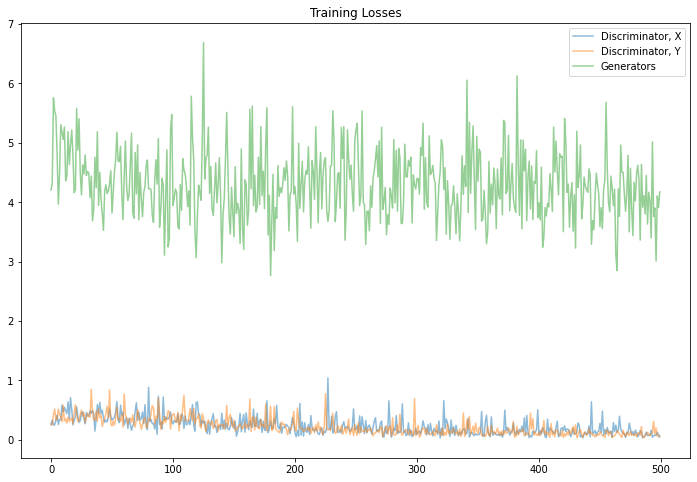

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).


Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [ ]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


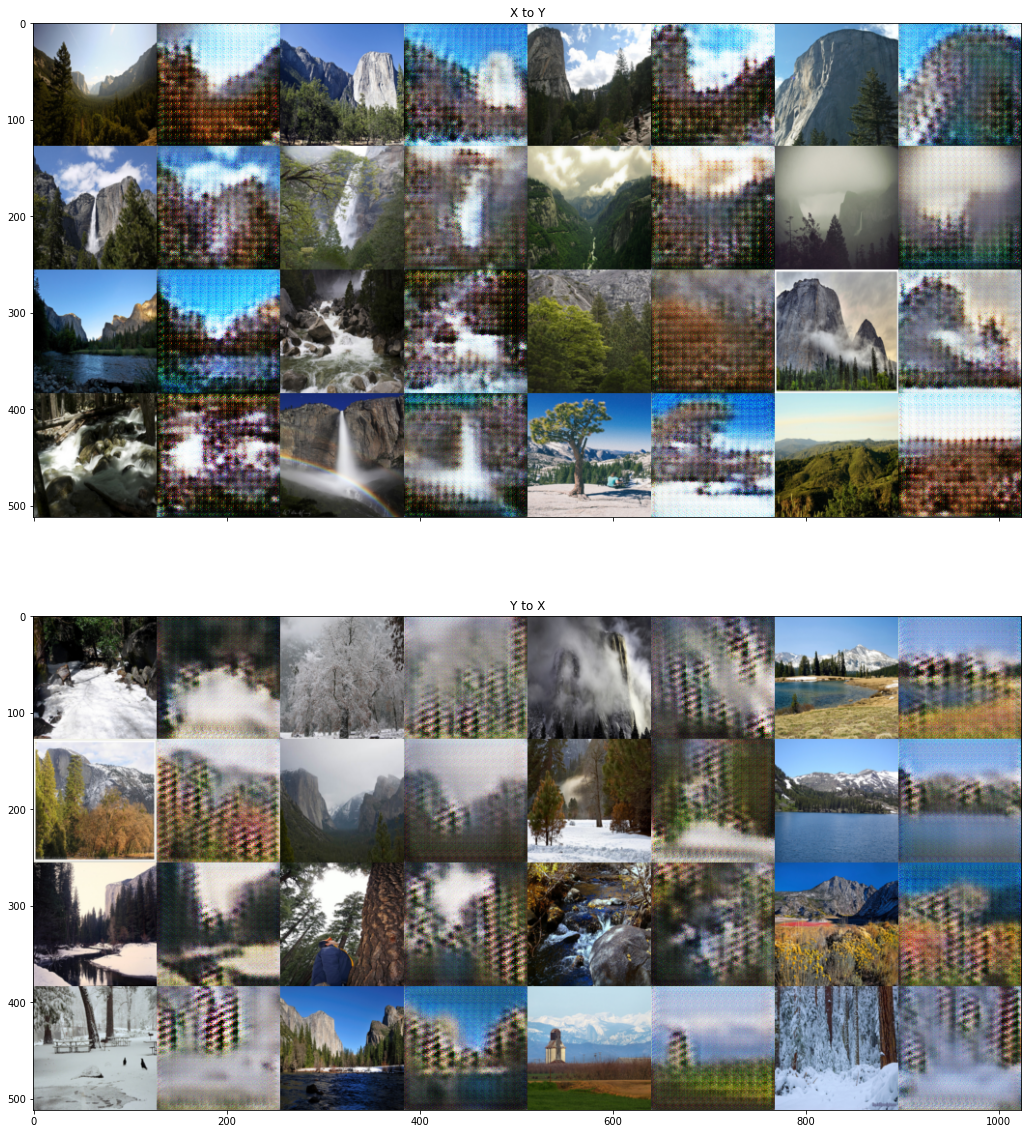

In [ ]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

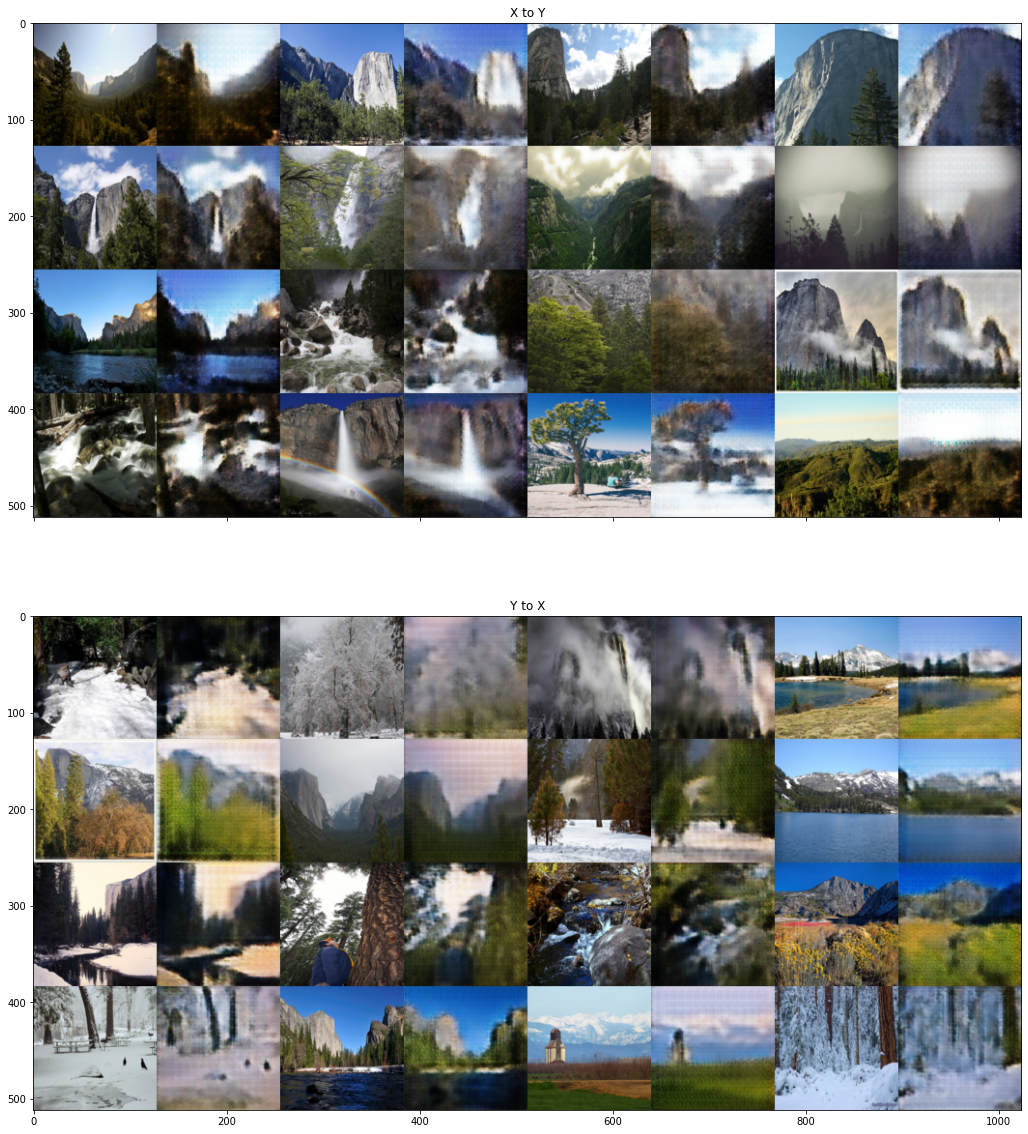

In [ ]:
  # view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')

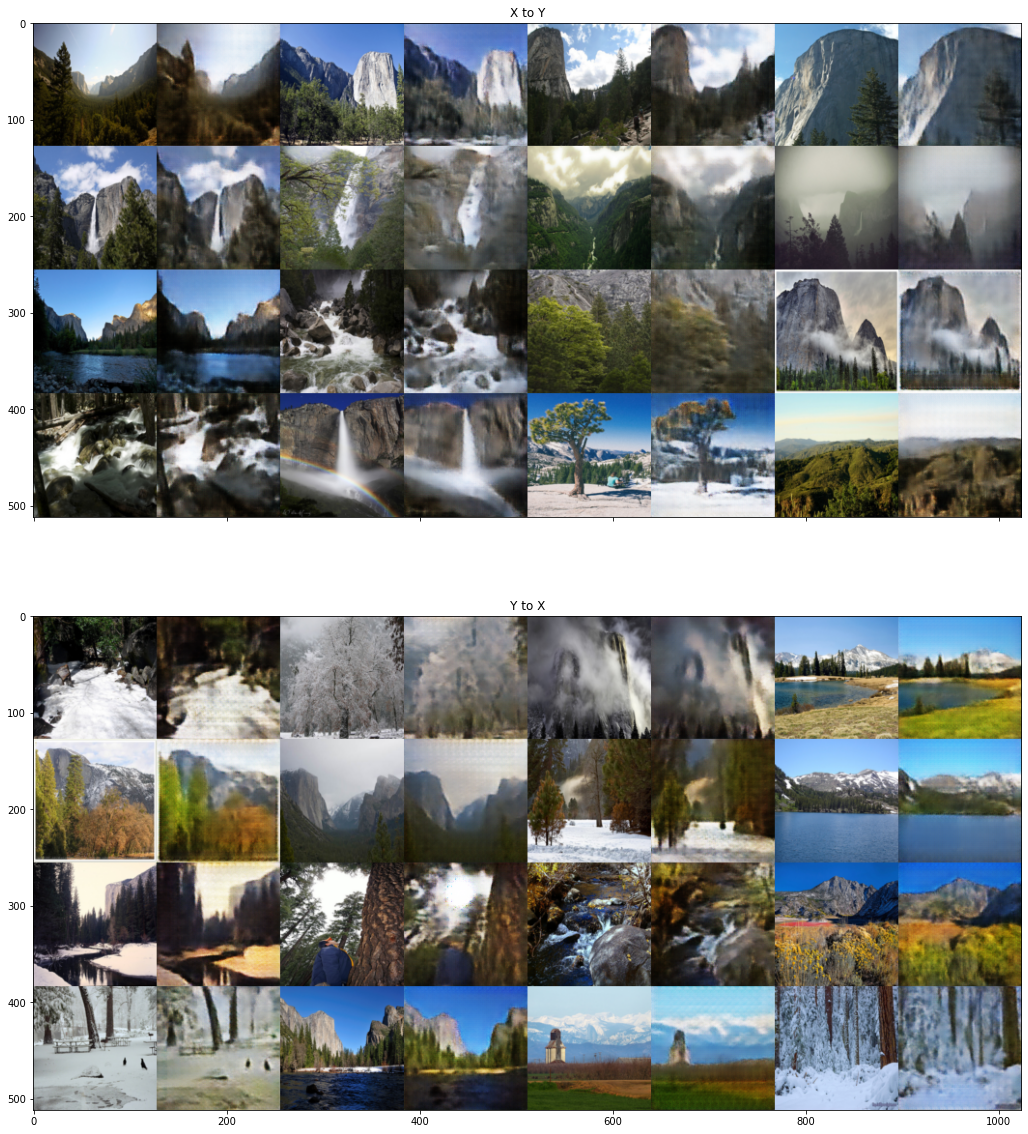

In [ ]:
view_samples(5000,'samples_cyclegan')